In [3]:
import os
import json
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import numpy as np
from geojson_DLNY_BS import domain
from shapely.geometry import shape 
import xarray as xr

In [5]:
from geojson_DLNY_BS import domain
from shapely.geometry import shape 
# ensure that the domain shape makes sense
domain_geometry = shape(domain['config'][0]['config'])

In [6]:

# Directory to start searching from
base_directory = '/data0/images/planet/emma/planet/DLNY/'


# List to collect matching filenames
low_overlap_files = []

# Walk through the directory and subdirectories
for root, dirs, files in os.walk(base_directory):
    for filename in files:
        if filename.endswith('_metadata.json'):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    geom = shape(data.get('geometry', {}))
                    if geom.is_valid and domain_geometry.is_valid:
                        intersection_area = geom.intersection(domain_geometry).area
                        total_area = geom.area
                        # print(f"Intersection area: {intersection_area}, Total area: {total_area}")
                        if total_area > 0:  # Avoid division by zero
                            overlap_percent = (intersection_area / domain_geometry.area) * 100
                            if overlap_percent < 95:
                                base_name = filename.replace('_metadata.json', '')
                                low_overlap_files.append((base_name, overlap_percent))
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Output the results
print("Files with overlap_percent < 85:")
for name, percent in low_overlap_files:
    print(f"{name}: {percent:.2f}%")


Files with overlap_percent < 85:
20230604_174935_60_2415: 57.54%
20230714_182750_93_2486: 79.62%
20230721_182933_35_2254: 59.83%
20230402_182234_68_2489: 72.54%
20230805_174520_96_2447: 81.54%
20200526_162518_0f2b: 70.47%
20230923_184908_09_2426: 91.08%
20220616_181830_73_249b: 89.00%
20230901_175130_20_24c9: 59.07%
20220923_182036_56_247b: 74.14%
20230727_174536_16_2449: 87.30%
20220417_181950_13_2478: 76.33%
20230911_175135_56_2429: 93.56%
20220924_181922_04_248c: 60.98%
20220716_183641_99_2402: 61.98%
20230604_174937_94_2415: 72.70%
20230405_174458_73_241a: 80.45%
20230704_182705_95_2482: 87.68%
20200413_184935_61_1058: 79.95%
20230429_174943_11_24af: 91.90%
20230329_174846_19_24c5: 94.34%
20230727_174538_26_2449: 71.96%
20230605_184546_01_2413: 76.68%
20230524_182321_88_249c: 51.82%
20220923_174646_20_242d: 61.83%
20230416_182320_20_248f: 90.26%
20220701_181923_57_2475: 87.09%
20220610_182215_54_2475: 72.71%
20220916_183256_04_240a: 86.94%
20230805_175203_05_24c9: 81.70%
20230425_1

In [7]:
#### functions
def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize to help visual understanding
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    # port to numpy
    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

In [ ]:

# Root directory
base_directory = '/data0/images/planet/emma/planet/DLNY'
# Loop through the base names from low_overlap_files
for base_name, overlap_percent in low_overlap_files:
    # Search for the corresponding .tif file
    pattern = os.path.join(base_directory, '**', f'{base_name}*', '**', 'PSScene', f'{base_name}*_SR_clip.tif')
    matching_files = glob.glob(pattern, recursive=True)

    if not matching_files:
        print(f"No .tif file found for {base_name}")
        continue

    tif_path = matching_files[0]  # Assume first match is correct

    try:
        ds = rxr.open_rasterio(tif_path, masked=True).squeeze()
        red_band, green_band, blue_band, nir_band, rgb_image = calc_rgb(ds)

        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(rgb_image)
        ax.set_title(f"{base_name}, Overlap: {overlap_percent:.2f}%")
        ax.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing {tif_path}: {e}")

In [6]:
p5 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/BUDD/PP/BUDD_V5_2022_model_output.nc')

p_V5_fsca_list = []
for i, date in enumerate(p5.time.values):
    p_slice = p5.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V5_fsca_list.append(fsca)
dates = pd.to_datetime(p5.time.values)
p_V5_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V5_fsca_list})

length of data record:  138


(0.0, 1.0)

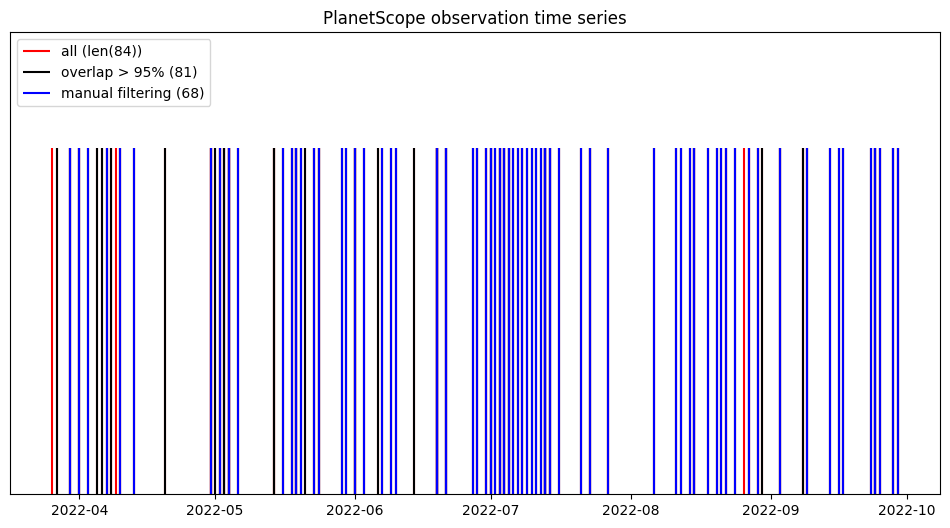

In [7]:
# user definitions
name = 'BUDD'
data_direc = f'/data0/images/planet/emma/planet/{name}/'
focus_year = 2022
subdirecs = sorted([d for d in glob.glob(data_direc + str(focus_year) + '*') if os.path.isdir(d)])
print('length of data record: ',len(subdirecs))

# get names from low_overlap_files
names = [name for name, overlap in low_overlap_files]
    
dates_filtered = []
all_dates = []
for dCount,direcc in enumerate(subdirecs):
    fname = glob.glob(direcc + '/*/PSScene/*SR_clip.tif')[0]
    id = fname.split('/')[-1].split('_3B')[0]
    date_0 = fname.split('/')[-1].split('_')[0]
    date_0 = pd.to_datetime(date_0, format='%Y%m%d')
    all_dates.append(date_0)
    if id not in names:
        date_1 = fname.split('/')[-1].split('_')[0]
        date_1 = pd.to_datetime(date_1, format='%Y%m%d')
        #save date
        dates_filtered.append(date_1)
        
        
# plot timeseries with vertical lines of dates


fig, ax = plt.subplots(figsize=(12, 6))
ax.vlines(all_dates, ymin=0, ymax=.75, colors='red', label=f'all (len({len(pd.Series(all_dates).unique())}))')
ax.vlines(dates_filtered, ymin=0, ymax=.75, colors='black', label=f'overlap > 95% ({len(pd.Series(dates_filtered).unique())})')
ax.vlines(p_V5_fsca_df['date'], ymin=0, ymax=.75, colors='blue', label=f"manual filtering ({len(p_V5_fsca_df['date'].unique())})")
ax.set_yticks([])
ax.set_title('PlanetScope observation time series')
# add legen
legend = ax.legend(facecolor='white', loc='upper left')
legend.set_alpha(1)
ax.set_ylim(0, 1)


        
        

In [9]:
# save low_overlap_files to csv
low_overlap_df = pd.DataFrame(low_overlap_files, columns=['base_name', 'overlap_percent'])
low_overlap_df.to_csv('/data0/images/planet/emma/planet/DLNY/DLNY_low_overlap_files_95.csv', index=False)